<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Exercise Set 2, Exercise 1 - Regression Neural Network

This is a copy of notebook ```nn-regr.ipynb``` for solving the following exercises:

  0. Run all cells.  
   
  1. Replace the sigmoid activation function with the **ReLU** function and observe how the shape of the predicted curve changes. *Revert back* afterwards to the *sigmoid* activation function.
   
  2. **Shift** the simulated data on the **x**-axis by **+50**.  
    
    2.1. **For the mathematically inclined:** Let $x' := x + 50$. Show or argue that it theoretically does not matter if you shift (use input $x'$) or not (use $x$):  *For any neural net $f(x)$ there is a neural net $f'(x')$ such that $f'(x') = f(x)$*. You may assume that $n=1$.
    
    2.2. Go to ADD YOUR CODE HERE and follow the instructions. Run all cells. What happens to the goodness of the fit? Do you have an explanation? Tip: Compute the net activations of the first layer manually right before training starts.

## Generate an Artificial Dataset

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense

tf.keras.backend.set_floatx('float64') # floating point precision 64 bits

In [2]:
def f(x):
    '''A simple one-dimensional function with a few extrema'''
    return np.sin(15 * x) + 9 * x - 9 * x**2

#### Simulate $(x, y)$ pairs as artificial data set

In [3]:
np.random.seed(1)
m = 100 # number of data points (examples)
x = np.linspace(0, 1, m) # equidistant in [0,1] (both boundaries included)
y_theoretical = f(x)     # the points on the curve
# ADD YOUR CODE HERE to shift x by +50, 1 line
x = x
# YOUR CODE ENDS
sigma = 0.1
y = y_theoretical + sigma * np.random.randn(m) # observations have noise (normal with mean 0 and variance sigma^2 = 0.01)

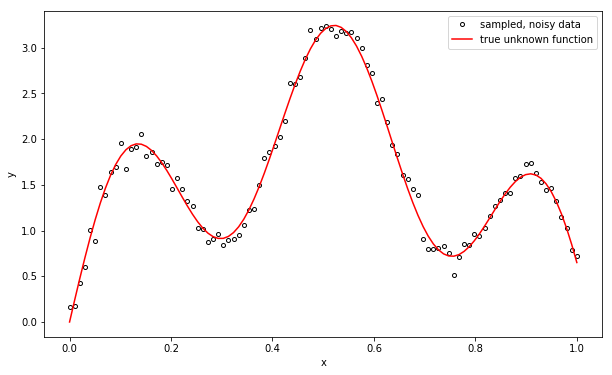

In [4]:
def plot_curve():
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(x, y, 'ko', fillstyle = 'none', markersize = 4, label = "sampled, noisy data") # ko: blac(k) circle
    ax.plot(x, y_theoretical, 'r', label = "true unknown function")
    plt.xlabel("x")
    plt.ylabel("y")
    return ax

ax = plot_curve()
ax.legend();

## Create Neural Network Model  
We will use [```tf.keras```](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras), a high-level approach to neural network design and learning. The NN shall have 2 hidden layers with 8 neurons each. As activation functions we chose the logistic sigmoid function $\sigma$.

<img src="nn8-8.png" alt="network architecture" width="500"/>

In [5]:
np.random.seed(1) # so we all get the same pseudorandom results

# a neural network is a stack of layers, in keras called "Sequential" model
model = tf.keras.models.Sequential() # so far the stack is empty, 0 layers

# add neural network layers one by one
# Dense is a fully connected layer, parametrized by a matrix of shape (input_units, output_units).
# The first number given in Dense is the number of output units, the number of input units is implicit.
# By default use_bias=True which adds output_units parameters for each layer
# REPLACE THE ACTIVATION FUNCTION HERE with tf.nn.relu
model.add(Dense(8, activation = tf.nn.sigmoid, input_dim = 1)) # input dimension only required for first layer
model.add(Dense(8, activation = tf.nn.sigmoid))
# YOUR CHANGES END HERE
model.add(Dense(1))

model.summary()     # summarizes layers and parameters
model.get_weights() # a look under the 'hood' for teaching purposes

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


[array([[ 0.3046885 ,  0.35312758, -0.40032592, -0.05615642,  0.64221749,
         -0.39501193,  0.74241401,  0.02154036]]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[-0.30100274,  0.43872255,  0.39803397, -0.53570105, -0.34418496,
          0.42160155, -0.15707484, -0.28897923],
        [-0.40673695, -0.25396169, -0.04601159,  0.18679462,  0.58042195,
         -0.28354931, -0.10674151, -0.41676101],
        [ 0.20601159,  0.14613907,  0.37407667, -0.18879014, -0.21437189,
         -0.39988491, -0.17585146, -0.29571614],
        [-0.54737166,  0.44505091,  0.15159907, -0.44612559, -0.03487305,
          0.29483558, -0.52900618, -0.58705433],
        [ 0.03552456, -0.49254826,  0.51959599, -0.2381871 , -0.32492301,
          0.57774909,  0.12541069,  0.39116693],
        [ 0.09190294, -0.08774423, -0.45930492, -0.0708959 ,  0.43854477,
         -0.50363119,  0.02780581,  0.5341162 ],
        [-0.25508206,  0.60468352, -0.0718094 ,  0.5718763 , -0.49474401,
         -0.01562761,

The weights are randomly initializated. This is important (why?) as can be the parameters of the distribution. We postpone parameter initialization to the next notebook.

### Compile the model

In [6]:
# define the loss, optimization algorithm and prepare the model for gradient computation 
opti = tf.keras.optimizers.Adam(learning_rate = 0.05) # Adam is a popular method for stochastic gradient descent
model.compile(optimizer = opti, loss = 'mse') # mean squared error

### Train the parameters (learning)

In [7]:
# execute the actual training 
history = model.fit(x, y, epochs=3000, verbose=0) # takes ~20s
# verbose = 1,2 gives more output

### Examine the learning progress

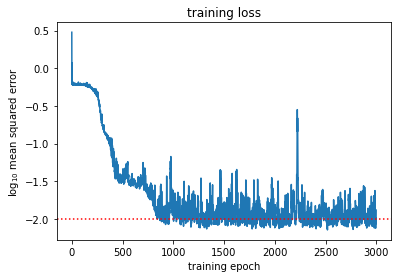

In [8]:
plt.plot(np.log10(history.history["loss"])); # one mse value per epoch
plt.title("training loss")
plt.xlabel("training epoch")
plt.ylabel(r"$\log_{10}$ mean squared error");
plt.axhline(y = np.log10(sigma**2), color = "red", linestyle = ":");

Observe that with our choice for the measurement noise the theoretical optimum for the mean squared error *on new data* is $10^{-2}$ (red dotted line).
### Use the model for predictions

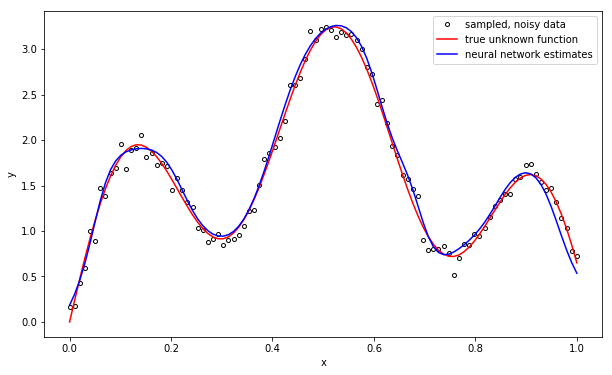

In [9]:
x_input = x.reshape((-1, 1)) # make x a matrix (with 1 column) as expected by predict
y_pred = model.predict(x_input)

ax = plot_curve()
ax.plot(x, y_pred, 'b', label = "neural network estimates") # (b)lue
ax.legend();